# 1. Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings("ignore")


# 2. Load Dataset


In [2]:
df = pd.read_csv("/kaggle/input/global-coffee-health-dataset/synthetic_coffee_health_10000.csv")
df.head()


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


# 3. Data Cleaning


In [3]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Fill missing target values with 'None'
df['Health_Issues'] = df['Health_Issues'].fillna('None')

# 4. Data Information


In [4]:
# Basic information
print("Data Info:")
print(df.info())
print("\nData Description:")
print(df.describe())
print("\nTarget distribution:")
print(df['Health_Issues'].value_counts())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       10000 non-null  int64  
 1   Age                      10000 non-null  int64  
 2   Gender                   10000 non-null  object 
 3   Country                  10000 non-null  object 
 4   Coffee_Intake            10000 non-null  float64
 5   Caffeine_mg              10000 non-null  float64
 6   Sleep_Hours              10000 non-null  float64
 7   Sleep_Quality            10000 non-null  object 
 8   BMI                      10000 non-null  float64
 9   Heart_Rate               10000 non-null  int64  
 10  Stress_Level             10000 non-null  object 
 11  Physical_Activity_Hours  10000 non-null  float64
 12  Health_Issues            10000 non-null  object 
 13  Occupation               10000 non-null  object 
 14  Smoking     

# 5. Target Distribution Visualization


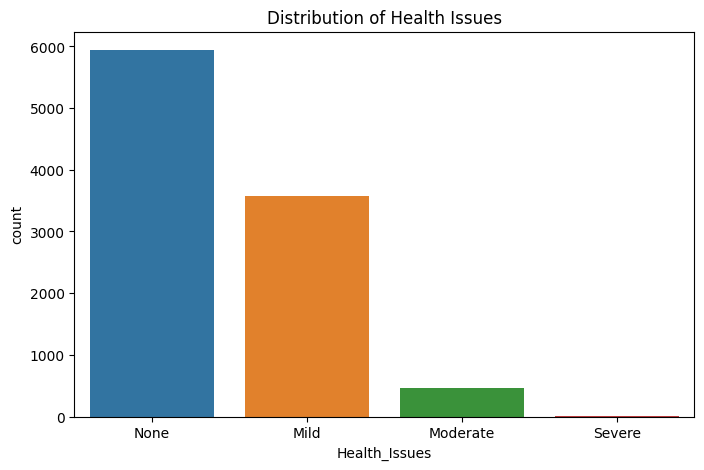

In [5]:
# Countplot of Health Issues
plt.figure(figsize=(8,5))
sns.countplot(x='Health_Issues', data=df)
plt.title("Distribution of Health Issues")
plt.show()

This plot shows the distribution of the Health Issues variable in the coffee health dataset.

Plot Interpretation
"None" is the largest category, with nearly **6000 cases**. This means most people in the dataset do not report health issues.

**"Mild"** health issues come second with about **3500 cases**.

**"Moderate"** health issues are significantly fewer (about **500 cases**).

**"Severe"** health issues are quite rare, **nearly negligible in the dataset**.

# 6. Correlation Matrix for Numerical Features


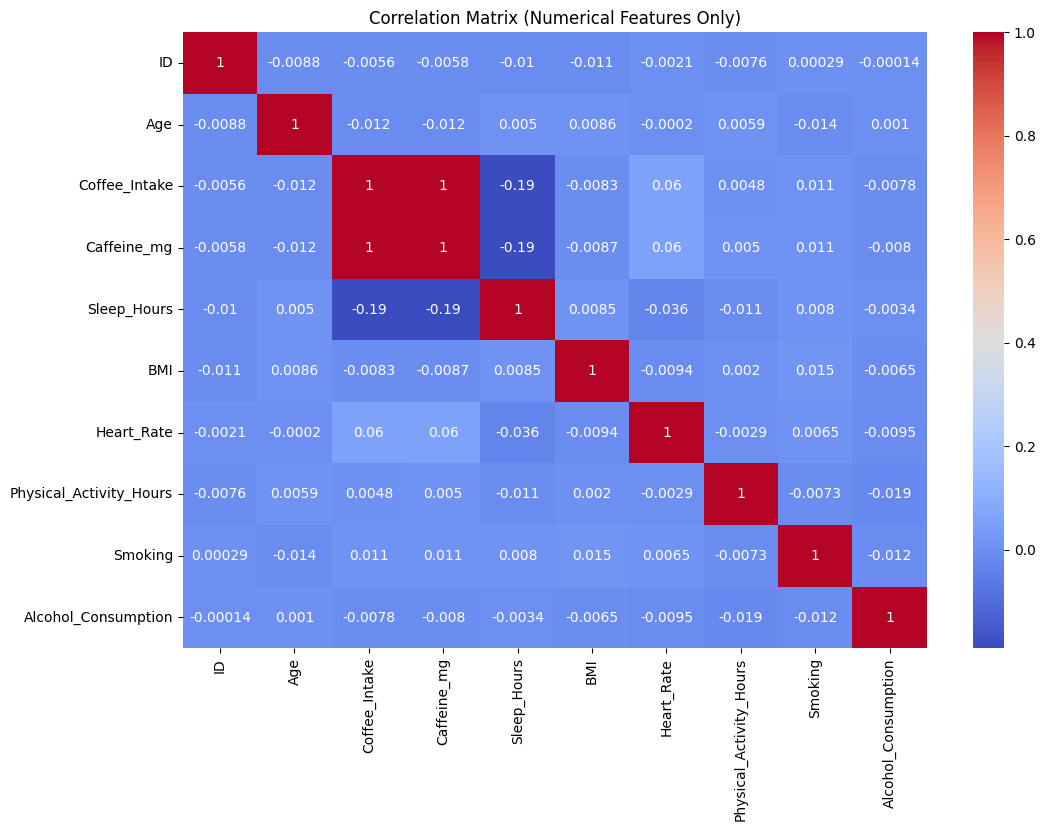

In [6]:
# Correlation Matrix
numerical_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
plt.figure(figsize=(12,8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Numerical Features Only)")
plt.show()


# 7. Exploratory Data Analysis (EDA) and Visualization
This section includes all visualizations for the dataset:
- KDE plots for numerical features
- Histograms for numerical features
- Pie charts for categorical features
- Pairplot with histograms for selected features
These plots help to understand feature distributions, relationships, and class proportions for `Health_Issues`.



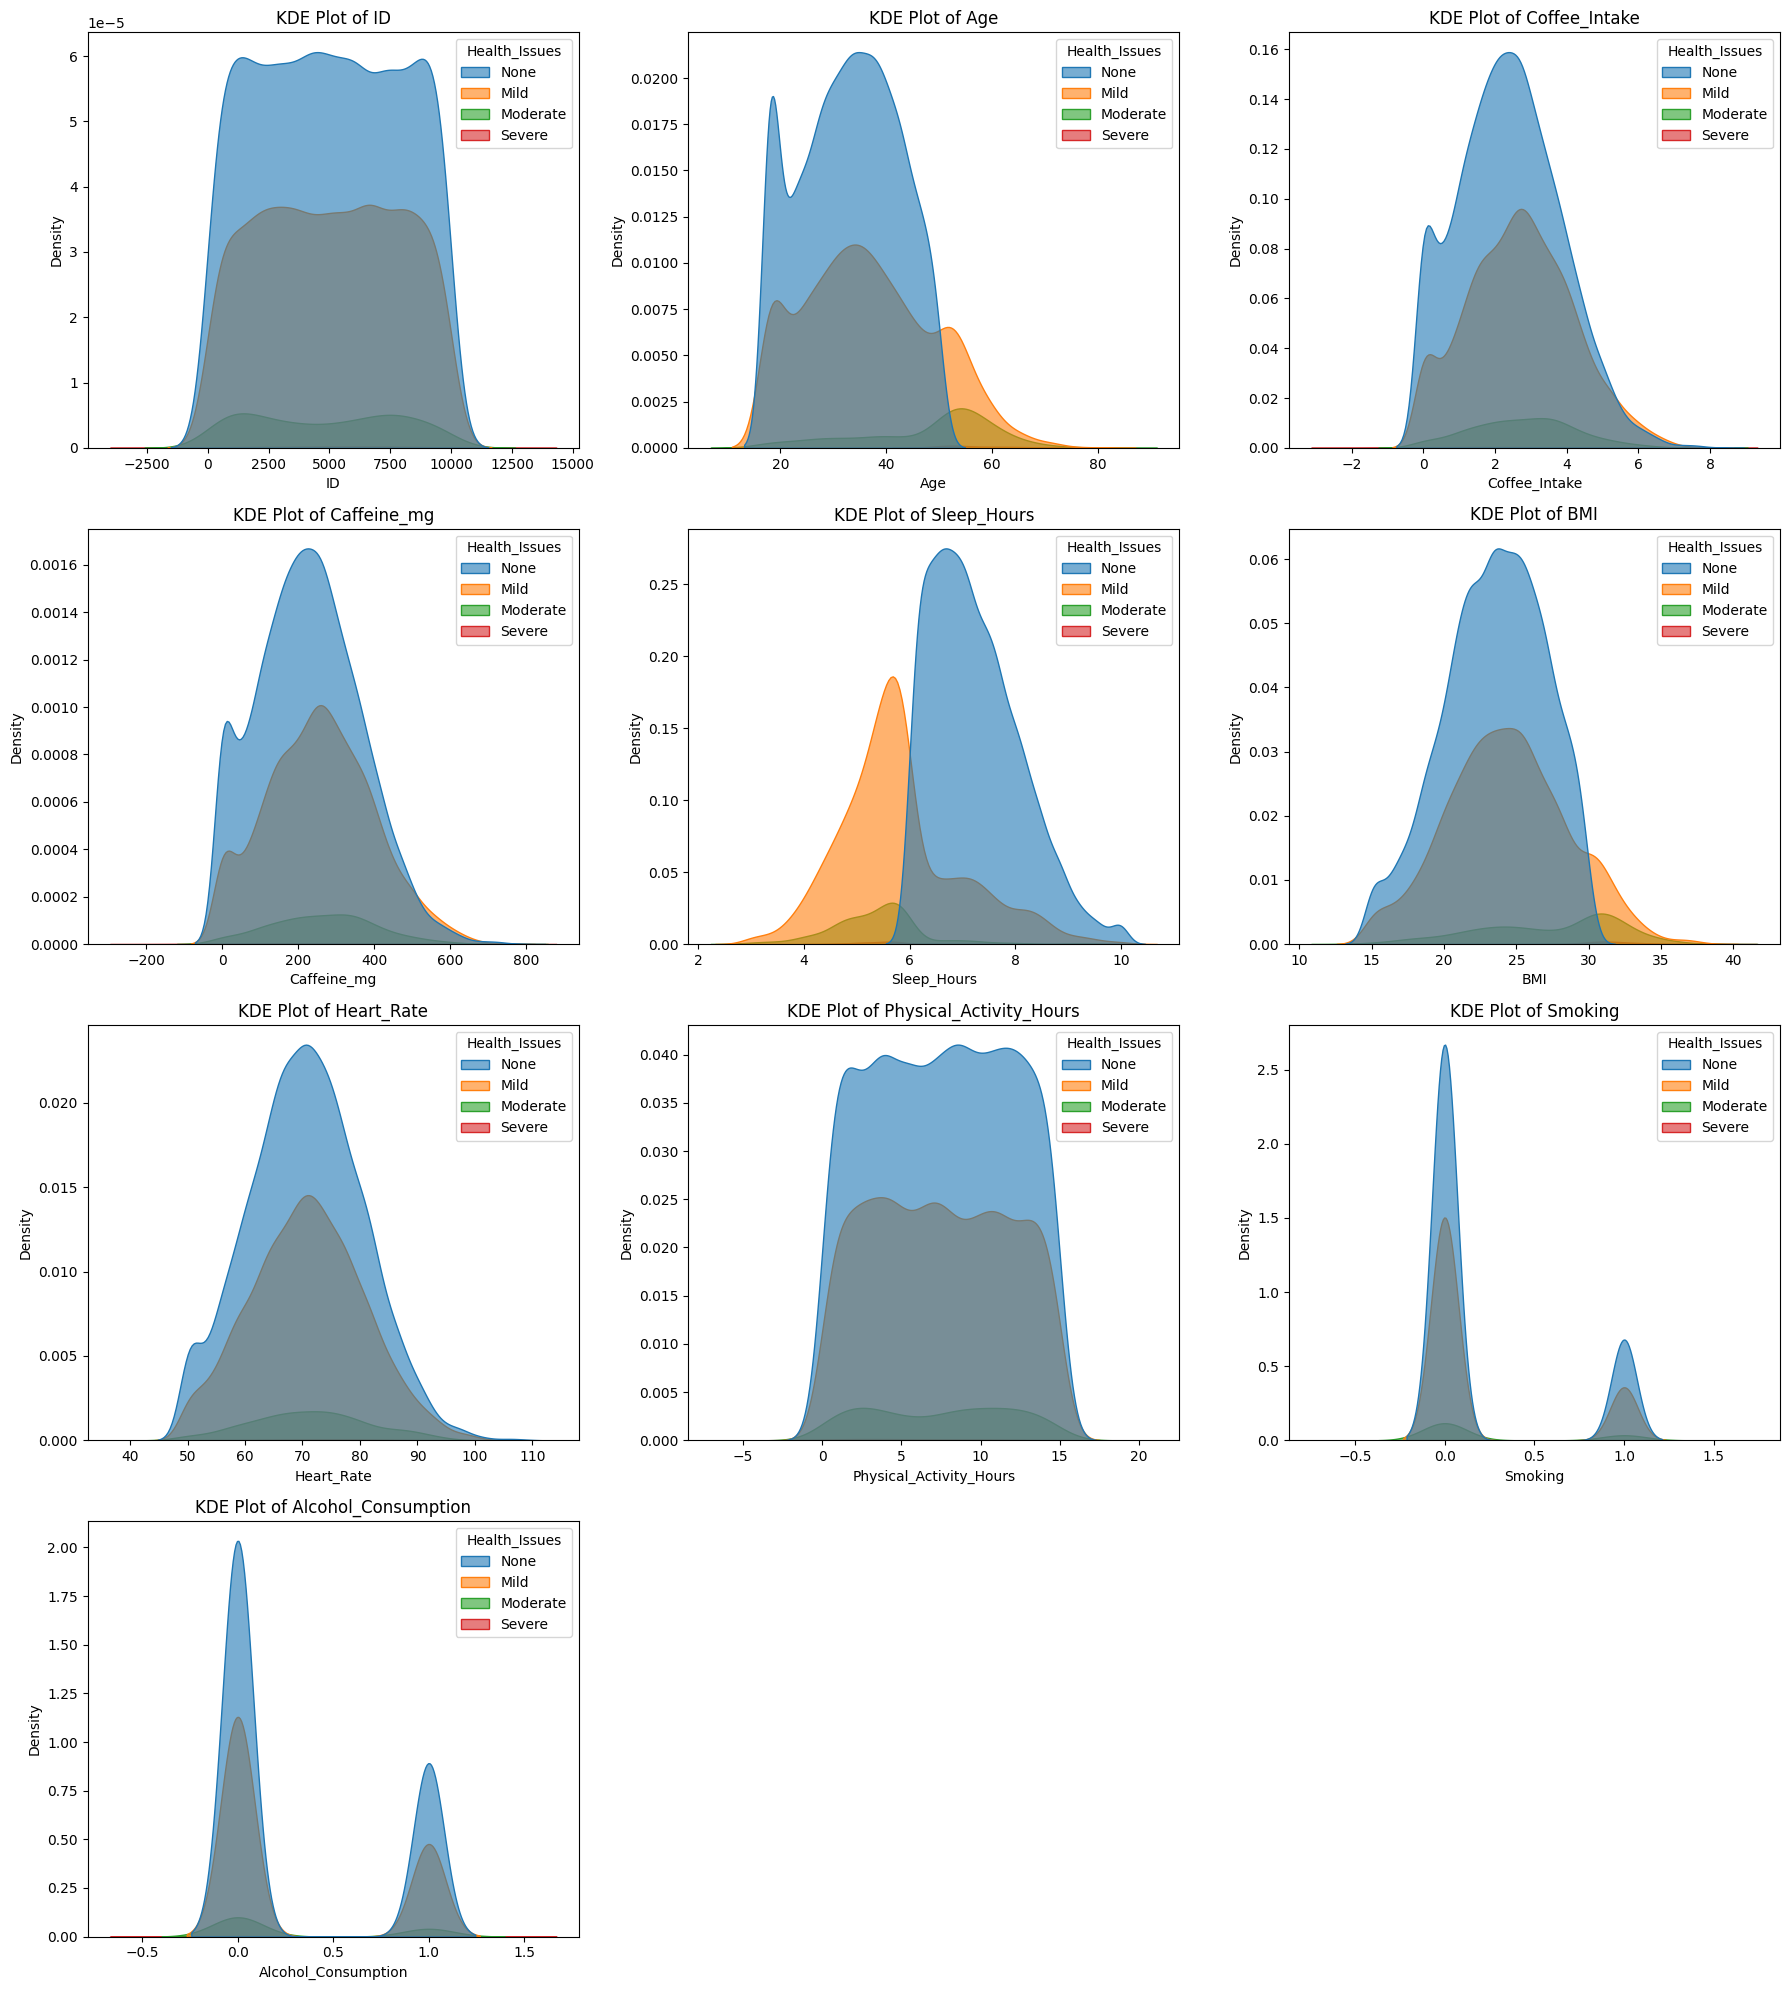

In [7]:
# KDE plots for numerical features
# Select numerical features
numerical_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()

# Grid size
n_cols = 3  # number of columns in the grid
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols  # calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.kdeplot(data=df, x=col, hue='Health_Issues', fill=True, ax=axes[i], alpha=0.6)
    axes[i].set_title(f'KDE Plot of {col}')

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

| Feature                     | Health Insights                                                                               |
|:----------------------------|:----------------------------------------------------------------------------------------------|
| ID                          | IDs are identifiers, not useful for health analysis.                                          |
| Age                         | None/Mild issues in younger ages; Moderate/Severe shift toward older ages.                    |
| Coffee Intake & Caffeine_mg | Higher intake linked with healthier individuals; Moderate/Severe less likely to consume much. |
| Sleep Hours                 | Healthy individuals sleep more; reduced sleep in those with health issues.                    |
| BMI                         | None/Mild clustered around healthy BMI; Moderate/Severe often overweight/obese.               |
| Heart Rate                  | Healthy: 60-80 bpm; Severe cases show wider, less healthy distributions.                      |
| Physical Activity Hours     | Healthiest report the most activity; less activity in severe cases.                           |
| Smoking                     | Most healthy do not smoke; smokers more represented in unhealthy groups.                      |
| Alcohol Consumption         | Most report no alcohol use; moderate use exists but not clearly linked to severity.           |



**General Insights:**                                                                                                                                                                                                      
Lifestyle indicators (coffee/caffeine intake, sleep, BMI) strongly correlate with health issue severity.

Most people in the dataset fall into the healthier groups, with distinctive distribution patterns for risk groups.
Tobacco and alcohol use remain low for most but show some relationship with health problems.

Greater physical activity and a healthy heart rate are related to the absence of health issues.

The distribution of risky behaviors (smoking, alcohol) is skewed toward the unhealthy groups, although severe cases remain rare.

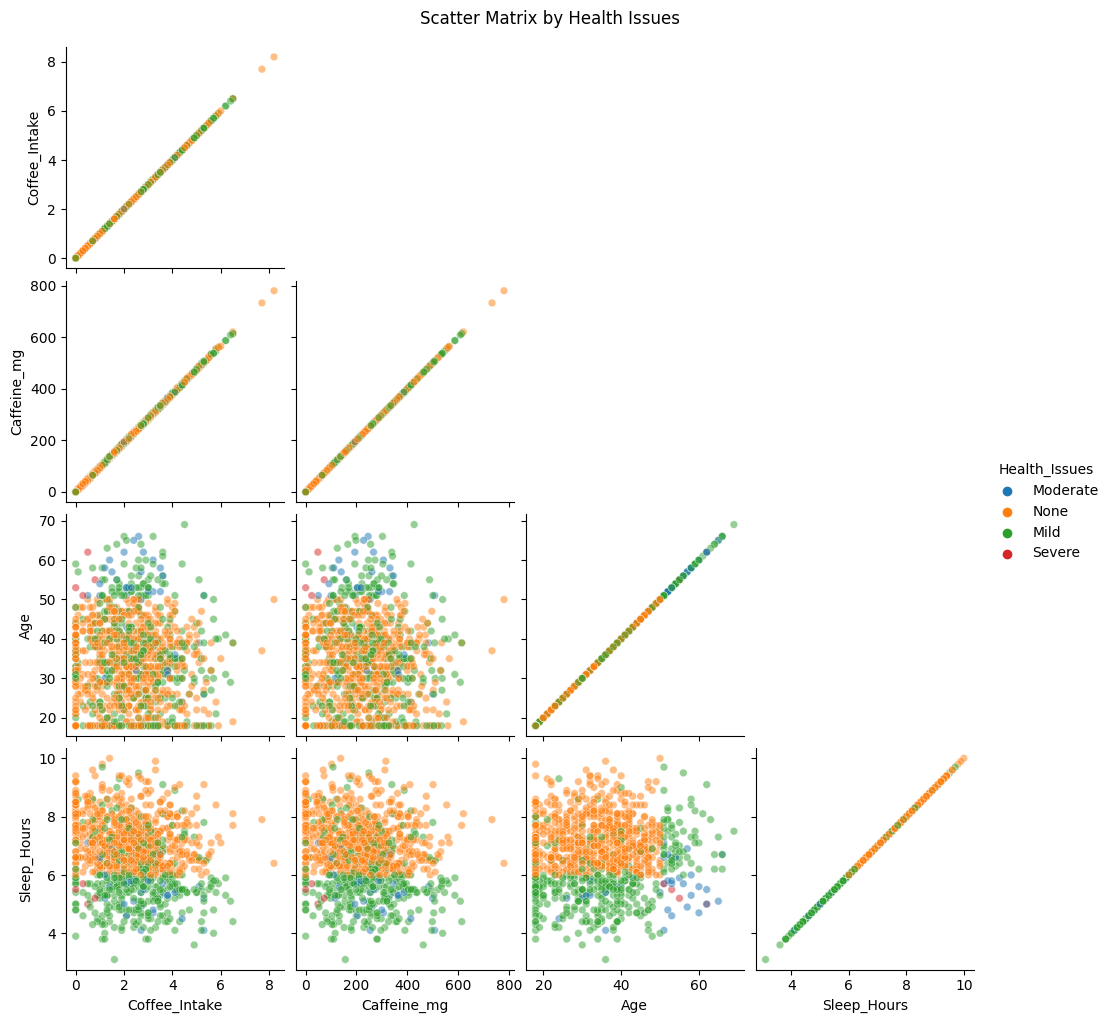

In [8]:
# Scatter matrix

# Select numerical features
selected_features = ['Coffee_Intake', 'Caffeine_mg', 'Age', 'Sleep_Hours']

# Sample data to speed up plotting
df_sample = df[selected_features + ['Health_Issues']].sample(1000, random_state=42)

# Scatter matrix 
sns.pairplot(df_sample, vars=selected_features, hue='Health_Issues', corner=True,
             diag_kind=None, plot_kws={'alpha':0.5, 's':30})
plt.suptitle("Scatter Matrix by Health Issues", y=1.02)
plt.show()

First this scatter matrix focuses on Coffee_Intake and Caffeine_mg.

There is a perfect linear relationship between coffee intake and caffeine amount, as expected: more coffee means more caffeine.

Health issues ("None", "Mild", "Moderate") are scattered along the trend line, with no distinct clustering visible for any category, indicating these features alone may not separate health outcomes.

The spread in the plot implies that other factors might be important for predicting health status.

Then scatter matrix includes Coffee_Intake, Caffeine_mg, Age, Sleep_Hours.

Coffee intake and caffeine are again linearly correlated.

Age and Sleep Hours show more scattered and less structured patterns.

Most "None" health issue cases (orange) spread nicely across all age and sleep values.

"Mild", "Moderate", and "Severe" health issues (other colors) do not form clear clusters; however, for sleep hours, people with health issues tend to have slightly lower sleep.

The plots suggest mild separation between groups, but no strong linear boundary. Exploring combinations of more features may improve separation.

--> Combined Insights
Coffee intake and caffeine are strongly correlated, reflecting logical data consistency.

No distinct visual separation in health groups based purely on these features; more complex models or combining additional variables may be needed to distinguish health classes.

Age and sleep hours can provide some stratification, but patterns are not strictly separated visually.

Using feature engineering or multivariate modeling could uncover subtler patterns not obvious in direct scatter plots.

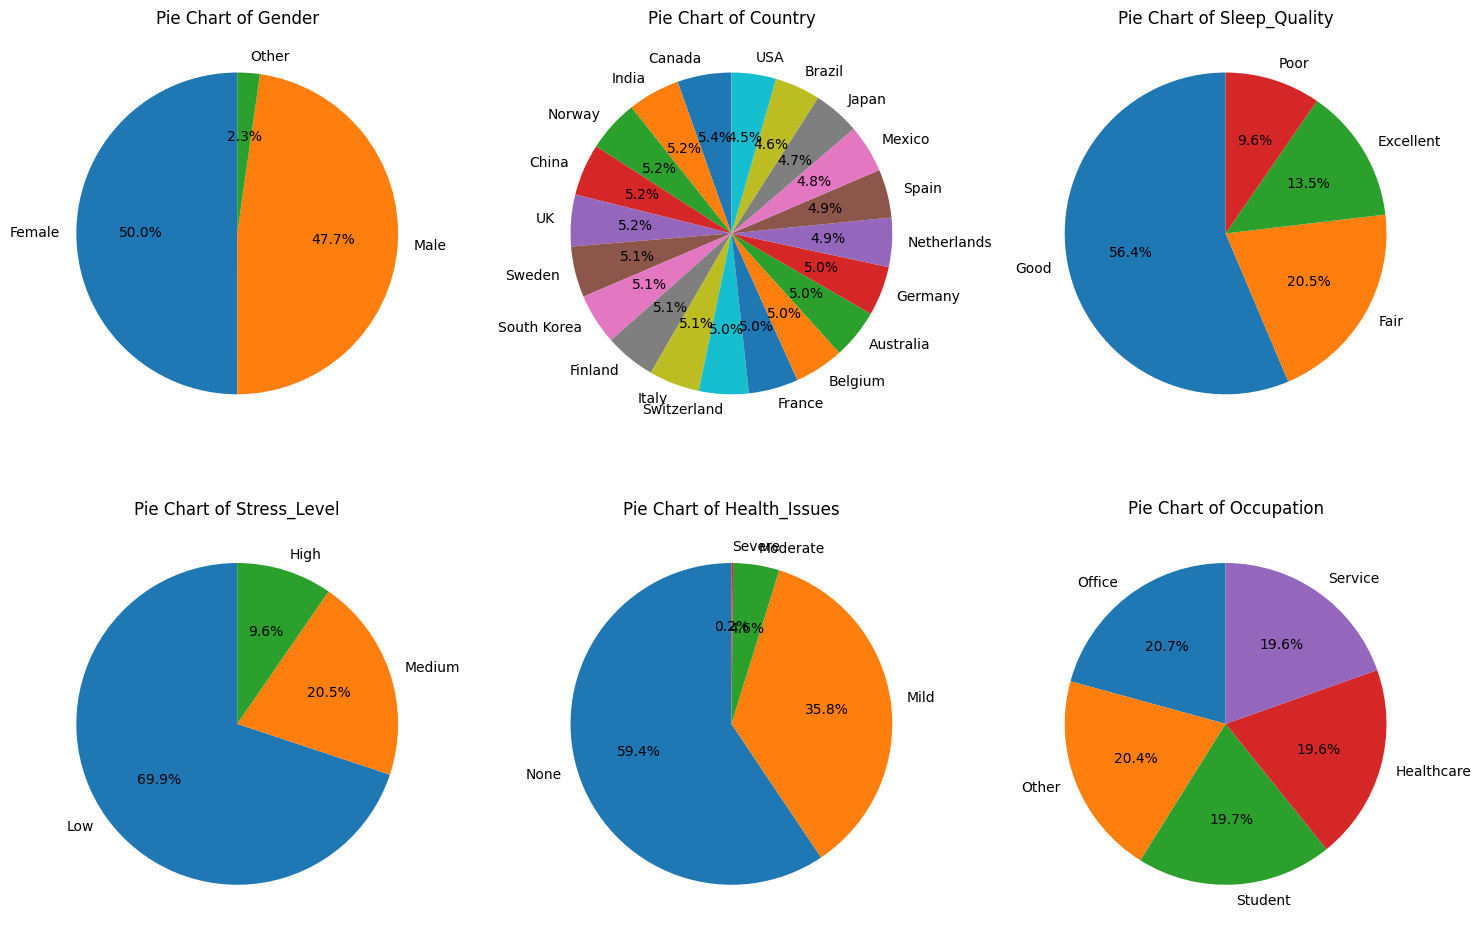

In [9]:
# Pie charts for categorical features
# Select categorical features
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Grid size
n_cols = 3  # number of columns in the grid
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols  # calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    counts = df[col].value_counts()
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'Pie Chart of {col}')

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The pie charts reveal several distribution patterns in the dataset. In stress levels, nearly **70%** of individuals report low stress, suggesting a generally healthy population or workplace, while high stress is quite uncommon. The health issues chart shows that **59%** of the sample are classified as "None," **36%** as "Mild," but only a tiny fraction have moderate or severe problems, again confirming most people are generally healthy. The occupation chart is notably balanced, with no single sector dominating—office, student, healthcare, service, and "other" each comprise about 20% of the population, which suggests diverse employment backgrounds.

Regarding gender, the population is almost equally split between male and female, with a very small "other" category, indicating good representation for both groups. For country, the dataset appears truly global: most nations included range between 4% and 5% representation, with no country overwhelmingly dominating. Sleep quality stands out, as over half report "good" sleep, followed by about one-fifth "fair," with "excellent" and "poor" sleep quality making up smaller shares—this suggests acceptable sleep hygiene for most, but still a minority at both extremes.

Overall, these pie charts highlight a relatively healthy, diverse, and balanced sample in terms of stress, health condition, occupation, gender, country, and sleep quality, presenting strong evidence that the dataset covers multiple demographic and lifestyle variables crucial for health studies.

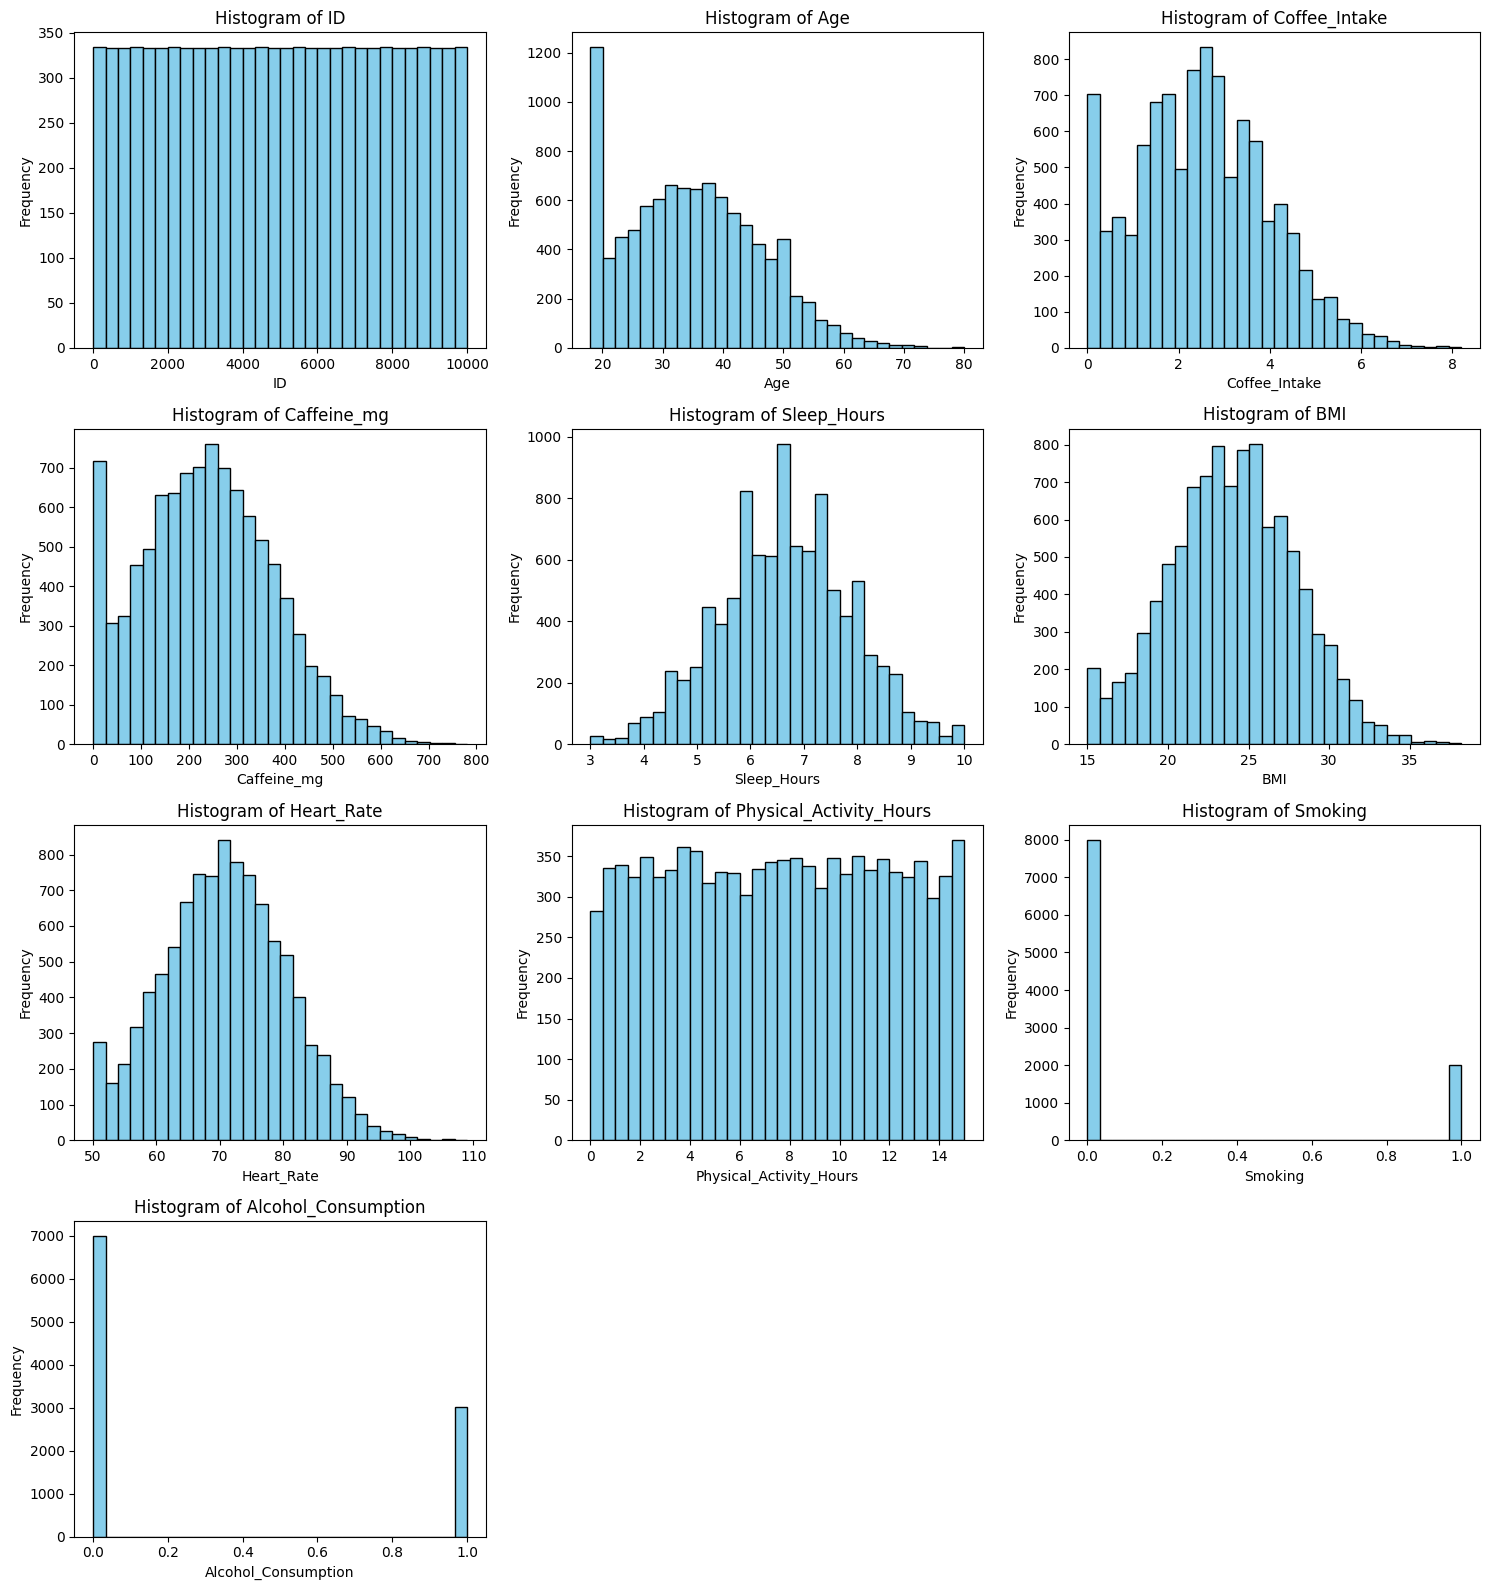

In [10]:
# Histograms for numerical features
# Select numerical features
numerical_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()

# Grid size
n_cols = 3  # number of columns in the grid
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols  # calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].hist(df[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


The histograms provide valuable insights into the distribution of key features in the global coffee health dataset. The ID histogram is uniformly distributed, confirming IDs are evenly assigned and not informative for analysis. Age displays a right-skewed pattern—most participants are young adults, with frequency dropping at older ages. Coffee intake and caffeine consumption both show right-skewness, with the majority consuming moderate amounts and fewer reporting very low or very high intake. Sleep hours are approximately normally distributed, centered on **6-7 hours**, indicating typical sleep duration for most individuals. BMI distribution has a mild right-skew, with most clustered in the healthy range and some in overweight.

Heart rate histogram is bell-shaped (normal distribution) centered around **70-75 bpm—characteristic** of a healthy adult population. Physical activity hours are evenly distributed, which suggests a wide range of exercise habits among participants. Smoking and alcohol histograms show most individuals report zero usage, with pronounced bars at non-user (0) and user (1), showing these behaviors are binary/categorical in nature and dominated by non-users. These visualizations confirm most people in the dataset lead moderately healthy lifestyles, have regular habits, and allow identification of possible outliers or patterns relevant for further study and prediction.

# 8. YData Profiling Report


In [11]:
# YData Profiling
profile = ProfileReport(df, title="Coffee Health Data Profiling", explorative=True)
profile.to_file("ydata_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 16/16 [00:00<00:00, 39.30it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 9. Features and Target


In [12]:
target_col = 'Health_Issues'
X = df.drop([target_col, 'ID'], axis=1)
y = df[target_col]

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()


# 10. Train-Test Split


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 11. Preprocessor (ColumnTransformer)


In [14]:
# ColumnTransformer: Feature Engineering
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols), # Scaling numeric features
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)   # Encoding categorical features
])

# 12. Pipeline Function


In [15]:
# Pipeline Creation (Feature Selection, Polynomial Features, PCA)
def create_pipeline(model):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_classif, k='all')),
        ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
        ('pca', PCA(n_components=10)),
        ('classifier', model)
    ])

# 13. Random Forest Model


In [16]:
rf_model = create_pipeline(
    RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42)
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, zero_division=0))
print(confusion_matrix(y_test, y_pred_rf))

joblib.dump(rf_model, "pipeline_Random_Forest.pkl")


Random Forest Results
Accuracy: 0.9525
              precision    recall  f1-score   support

        Mild       0.93      0.94      0.94       716
    Moderate       0.86      0.58      0.69        93
        None       0.97      0.99      0.98      1188
      Severe       0.00      0.00      0.00         3

    accuracy                           0.95      2000
   macro avg       0.69      0.63      0.65      2000
weighted avg       0.95      0.95      0.95      2000

[[ 670    7   39    0]
 [  39   54    0    0]
 [   7    0 1181    0]
 [   1    2    0    0]]


['pipeline_Random_Forest.pkl']

# 14. Logistic Regression Model


In [17]:
lr_model = create_pipeline(
    LogisticRegression(max_iter=2000, solver='lbfgs', class_weight='balanced')
)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, zero_division=0))
print(confusion_matrix(y_test, y_pred_lr))

joblib.dump(lr_model, "pipeline_Logistic_Regression.pkl")


Logistic Regression Results
Accuracy: 0.862
              precision    recall  f1-score   support

        Mild       0.86      0.76      0.81       716
    Moderate       0.40      0.74      0.52        93
        None       0.94      0.93      0.94      1188
      Severe       0.11      0.67      0.19         3

    accuracy                           0.86      2000
   macro avg       0.58      0.78      0.61      2000
weighted avg       0.89      0.86      0.87      2000

[[ 547  101   65    3]
 [  11   69    0   13]
 [  81    1 1106    0]
 [   0    1    0    2]]


['pipeline_Logistic_Regression.pkl']

# 15. Support Vector Machine (SVM) Model


In [18]:
svm_model = create_pipeline(
    SVC(class_weight='balanced', probability=True)
)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("SVM Results")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, zero_division=0))
print(confusion_matrix(y_test, y_pred_svm))

joblib.dump(svm_model, "pipeline_SVM.pkl")


SVM Results
Accuracy: 0.9455
              precision    recall  f1-score   support

        Mild       0.96      0.89      0.92       716
    Moderate       0.56      0.88      0.69        93
        None       0.98      0.99      0.99      1188
      Severe       1.00      0.33      0.50         3

    accuracy                           0.95      2000
   macro avg       0.88      0.77      0.77      2000
weighted avg       0.96      0.95      0.95      2000

[[ 636   62   18    0]
 [  11   82    0    0]
 [  16    0 1172    0]
 [   0    2    0    1]]


['pipeline_SVM.pkl']

# 16. K-Nearest Neighbors (KNN) Model


In [19]:
knn_model = create_pipeline(
    KNeighborsClassifier(n_neighbors=5)
)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

print("KNN Results")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, zero_division=0))
print(confusion_matrix(y_test, y_pred_knn))

joblib.dump(knn_model, "pipeline_KNN.pkl")


KNN Results
Accuracy: 0.924
              precision    recall  f1-score   support

        Mild       0.92      0.87      0.89       716
    Moderate       0.91      0.45      0.60        93
        None       0.93      0.99      0.96      1188
      Severe       0.00      0.00      0.00         3

    accuracy                           0.92      2000
   macro avg       0.69      0.58      0.61      2000
weighted avg       0.92      0.92      0.92      2000

[[ 625    3   88    0]
 [  48   42    3    0]
 [   7    0 1181    0]
 [   2    1    0    0]]


['pipeline_KNN.pkl']

# 17. Artificial Neural Network (ANN) Model


In [20]:
ann_model = create_pipeline(
    MLPClassifier(hidden_layer_sizes=(150,100), max_iter=1000)
)
ann_model.fit(X_train, y_train)
y_pred_ann = ann_model.predict(X_test)

print("ANN Results")
print("Accuracy:", accuracy_score(y_test, y_pred_ann))
print(classification_report(y_test, y_pred_ann, zero_division=0))
print(confusion_matrix(y_test, y_pred_ann))

joblib.dump(ann_model, "pipeline_ANN.pkl")


ANN Results
Accuracy: 0.978
              precision    recall  f1-score   support

        Mild       0.97      0.97      0.97       716
    Moderate       0.86      0.86      0.86        93
        None       0.99      0.99      0.99      1188
      Severe       1.00      1.00      1.00         3

    accuracy                           0.98      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.98      0.98      0.98      2000

[[ 691   13   12    0]
 [  13   80    0    0]
 [   6    0 1182    0]
 [   0    0    0    3]]


['pipeline_ANN.pkl']

# 18. Model Comparison


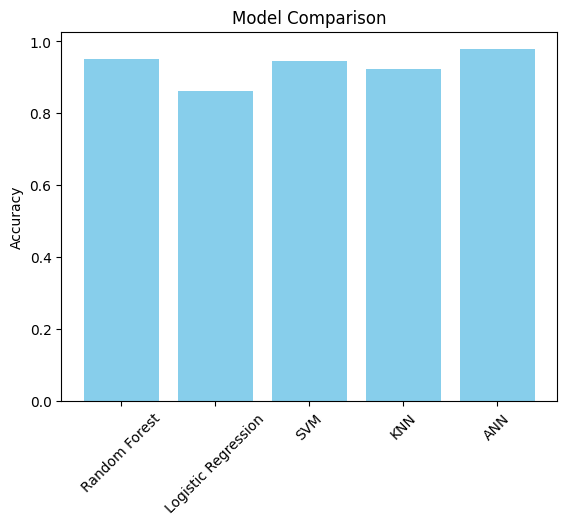

In [21]:
# Compare models by test accuracy
results = {
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "Logistic Regression": accuracy_score(y_test, y_pred_lr),
    "SVM": accuracy_score(y_test, y_pred_svm),
    "KNN": accuracy_score(y_test, y_pred_knn),
    "ANN": accuracy_score(y_test, y_pred_ann)
}

plt.bar(results.keys(), results.values(), color="skyblue")
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.xticks(rotation=45)
plt.show()


# 19. Best Model Selection and Save


In [22]:
best_model_name = max(results, key=results.get)
print("Best Model:", best_model_name)

joblib.dump(eval(best_model_name.lower().replace(" ","_") + "_model"), "best_model.pkl")


Best Model: ANN


['best_model.pkl']

# 20. Predict on Random Samples


In [23]:
# Load best model pipeline
loaded_pipeline = joblib.load("best_model.pkl")
sample_pred = loaded_pipeline.predict(X_test.head())
print("Predictions for sample:", sample_pred)
print("True Labels:", y_test.head().values)


Predictions for sample: ['None' 'Mild' 'None' 'None' 'Mild']
True Labels: ['None' 'Mild' 'None' 'None' 'Mild']


In [24]:
# Load best model pipeline
loaded_pipeline = joblib.load("best_model.pkl")
sample_data = pd.DataFrame({
    'Age': [35, 47, 22, 59, 41],
    'Gender': ['Male', 'Female', 'Male', 'Female', 'Male'],
    'Country': ['USA', 'Brazil', 'Italy', 'Japan', 'India'],
    'Coffee_Intake': [2, 5, 3, 1, 0],  # cups/day
    'Caffeine_mg': [150, 300, 120, 80, 0],  # estimated mg/day
    'Sleep_Hours': [7, 6, 8, 5, 7],
    'Sleep_Quality': ['Good', 'Fair', 'Good', 'Poor', 'Fair'],
    'BMI': [24.5, 27.6, 22.0, 25.3, 28.2],
    'Heart_Rate': [72, 78, 68, 85, 76],
    'Stress_Level': ['Low', 'High', 'Medium', 'High', 'Low'],
    'Physical_Activity_Hours': [1, 0.5, 1.5, 1, 0.5],
    'Occupation': ['Office', 'Manual', 'Student', 'Retired', 'Office'],
    'Smoking': [0, 1, 0, 0, 1],
    'Alcohol_Consumption': [1, 0, 2, 1, 1]

})
sample_pred = loaded_pipeline.predict(sample_data)
print("Predictions for sample:", sample_pred)
print("True Labels:", y_test.head().values)

Predictions for sample: ['None' 'Mild' 'None' 'Moderate' 'None']
True Labels: ['None' 'Mild' 'None' 'None' 'Mild']
